# RTT Dataset

[DANDI](https://dandiarchive.org/#/dandiset/000129)

## 1 Overview

The RTT dataset consists of data from a single recording session of a macaque performing self-paced reaches between random elements of a grid, with neural activity recorded from the primary motor cortex. This data was provided by Joseph O'Doherty and Philip Sabes from the University of California San Francisco, and you can read more about the experiment design and data collection in this [paper](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) and on their [Zenodo page](https://zenodo.org/record/3854034).

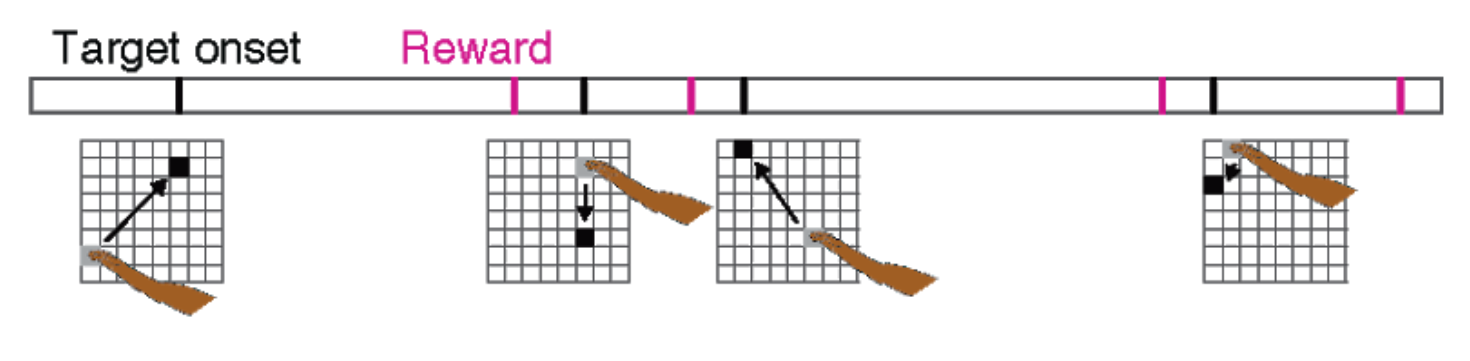

In [1]:
from IPython.display import display, Image
display(Image(filename="img/rtt.png", embed=True))

### 1.1 Task

In the randomn target task, the subject reached continuously between randomly selected elements of an 8x8 grid, as shown in the figure above. This task design differs significantly from typical reaching tasks since it lacks clear trial structure, pre-movement delay periods, and repeated, constrained task conditions. The resulting motions, instead of being well-planned and rehearsed, are very naturalistic and much closer to typical motor behavior.

### 1.2 Data

The neural activity for this dataset was recorded from the primary motor cortex. The position of the target, the position of the monkey's hand, and the position of the cursor, which was controlled by the monkey's hand position, were also recorded during the experiment. From the recorded hand position, we calculated hand velocity by estimating the gradient of hand position.

## 2 Exploring the data

### 2.1 Setup

First, let's make the necessary imports and load the data.


In [2]:
## Download dataset and required packages if necessary
# !pip install git+https://github.com/neurallatents/nlb_tools.git
# !pip install dandi
# !dandi download https://gui.dandiarchive.org/#/dandiset/000129

In [3]:
## Imports

# %matplotlib widget # uncomment for interactive plots
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [4]:
## Load dataset
dataset = NWBDataset("~/lvm/code/dandi/000129/sub-Indy", "*train", split_heldout=False)

### 2.2 Continuous data

The provided continuous data includes:
* `cursor_pos` - x and y position of the cursor, in mm
* `finger_pos` - position of the monkey's finger in space. The x and y dimensions correspond to the same dimensions for the cursor and target, while the z direction points directly into the screen. The cursor position was determined from the x and y positions of the monkey's hand
* `finger_vel` - x and y velocity of the monkey's finger in mm/s, calculated offline using `np.gradient`. z velocity was excluded as it is not relevant to the task
* `target_pos` - x and y position of the target, in mm
* `spikes` - spike times binned at 1 ms

In [5]:
## View 'dataset.data'
dataset.data

signal_type            cursor_pos            finger_pos                        \
channel                         x          y          x          y          z   
clock_time                                                                      
0 days 00:00:00         -4.368126  56.778511  -4.357695  56.758063  94.737781   
0 days 00:00:00.001000  -4.367445  56.776709  -4.356471  56.755696  94.736662   
0 days 00:00:00.002000  -4.366716  56.774849  -4.355222  56.753297  94.735519   
0 days 00:00:00.003000  -4.365940  56.772930  -4.353950  56.750865  94.734355   
0 days 00:00:00.004000  -4.365118  56.770954  -4.352654  56.748402  94.733168   
...                           ...        ...        ...        ...        ...   
0 days 00:10:49.095000  21.912910  21.772385  21.910600  21.775553  87.763974   
0 days 00:10:49.096000  21.912572  21.772658  21.910276  21.775811  87.764095   
0 days 00:10:49.097000  21.912233  21.772935  21.909954  21.776069  87.764220   
0 days 00:10:49.098000  21.911894  21.773216  21.909634  21.776326  87.764350   
0 days 00:10:49.099000  21.911554  21.773500  21.909317  21.776582  87.764485   

signal_type            finger_vel           spikes            ...            \
channel                         x         y    201  203  204  ... 9201 9203   
clock_time                                                    ...             
0 days 00:00:00          1.211079 -2.349968    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.001000   1.236134 -2.383193    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.002000   1.260579 -2.415633    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.003000   1.284410 -2.447283    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.004000   1.307626 -2.478143    0.0  0.0  0.0  ...  0.0  0.0   
...                           ...       ...    ...  ...  ...  ...  ...  ...   
0 days 00:10:49.095000  -0.325126  0.258578    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:49.096000  -0.323063  0.258088    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:49.097000  -0.320876  0.257396    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:49.098000  -0.318591  0.256517    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:49.099000  -0.316212  0.255452    0.0  0.0  0.0  ...  0.0  0.0   

signal_type                                          target_pos        
channel                9301 9403 9501 9502 9601 9602          x     y  
clock_time                                                             
0 days 00:00:00         0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
0 days 00:00:00.001000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
0 days 00:00:00.002000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
0 days 00:00:00.003000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
0 days 00:00:00.004000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
...                     ...  ...  ...  ...  ...  ...        ...   ...  
0 days 00:10:49.095000  0.0  0.0  0.0  0.0  0.0  0.0       37.5  82.5  
0 days 00:10:49.096000  0.0  0.0  0.0  0.0  0.0  0.0       37.5  82.5  
0 days 00:10:49.097000  0.0  0.0  0.0  0.0  0.0  0.0       37.5  82.5  
0 days 00:10:49.098000  0.0  0.0  0.0  0.0  0.0  0.0       37.5  82.5  
0 days 00:10:49.099000  0.0  0.0  0.0  0.0  0.0  0.0       37.5  82.5  

[649100 rows x 139 columns]

### 2.3 Trial metadata

The RTT dataset lacks clear trial structure. For the benchmark competition, we define trials to be 600 ms segments for convenience. For this demonstration, however, we will redefine trials to be each period in which the target position does not change, which constitutes a single reach. Note that, because some data were removed for benchmark evaluation, a few trials at the edge of each file will not contain complete reaches, so we will discard them.

In [6]:
## Make trial data

# Find when target pos changes
has_change = dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
# Find if target pos change corresponds to NaN-padded gap between files
change_nan = dataset.data[has_change].isna().any(axis=1)
# Drop trials containing the gap and immediately before and after, as those trials may be cut short
drop_trial = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True))[:-1]
# Add start and end times to trial info
change_times = dataset.data.index[has_change]
start_times = change_times[:-1][~drop_trial]
end_times = change_times[1:][~drop_trial]
# Get target position per trial
target_pos = dataset.data.target_pos.loc[start_times].to_numpy().tolist()
# Compute reach distance and angle
reach_dist = dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times - pd.Timedelta(1, 'ms')].to_numpy()
reach_angle = np.arctan2(reach_dist[:, 1], reach_dist[:, 0]) / np.pi * 180
# Create trial info
dataset.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times)),
    'start_time': start_times,
    'end_time': end_times,
    'target_pos': target_pos,
    'reach_dist_x': reach_dist[:, 0],
    'reach_dist_y': reach_dist[:, 1],
    'reach_angle': reach_angle,
})

In [7]:
## View 'dataset.trial_info'
dataset.trial_info

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
0,0,0 days 00:00:01.352000,0 days 00:00:02.712000,"[-37.5, 82.5]",-90.0,15.0,170.537678
1,1,0 days 00:00:02.712000,0 days 00:00:03.952000,"[22.5, 67.5]",60.0,-15.0,-14.036243
2,2,0 days 00:00:03.952000,0 days 00:00:05.112000,"[-22.5, 7.5]",-45.0,-60.0,-126.869898
3,3,0 days 00:00:05.112000,0 days 00:00:06.364000,"[-52.5, 67.5]",-30.0,60.0,116.565051
4,4,0 days 00:00:06.364000,0 days 00:00:07.672000,"[-37.5, 52.5]",15.0,-15.0,-45.000000
...,...,...,...,...,...,...,...
535,535,0 days 00:10:41.644000,0 days 00:10:42.864000,"[-52.5, 82.5]",-105.0,0.0,180.000000
536,536,0 days 00:10:42.864000,0 days 00:10:43.732000,"[-22.5, 67.5]",30.0,-15.0,-26.565051
537,537,0 days 00:10:43.732000,0 days 00:10:46.496000,"[-7.5, 7.5]",15.0,-60.0,-75.963757
538,538,0 days 00:10:46.496000,0 days 00:10:47.924000,"[-52.5, 37.5]",-45.0,30.0,146.309932


### 2.4 Reach trajectories

Let's quickly plot the first few reaches to better visualize the random target task. We will mark targets with dots and use a color map to indicate time.

In [8]:
## Optional resampling
# It may be beneficial to resample the data before you proceed to the analysis sections,
# as they may be fairly memory-intensive. However, we have not tested this notebook at bin sizes
# of over 20 ms, so we cannot guarantee that everything will work as intended at
# those larger bin sizes.
dataset.resample(5)

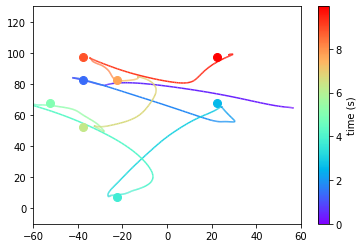

In [9]:
## Plot a few reaches

# Extract start and end times, target positions
start = dataset.trial_info.iloc[0].start_time # arbitrarily using 1st through 6th reaches
end = dataset.trial_info.iloc[7].end_time - pd.Timedelta(1, 'ms')
targets = dataset.trial_info.target_pos.iloc[0:8].to_numpy().tolist()
tts = dataset.trial_info.end_time.iloc[0:8] - start

# Get cursor position data
reach_data = dataset.data.cursor_pos.loc[start:end].to_numpy().reshape(-1, 1, 2)
reach_seg = np.concatenate([reach_data[:-1], reach_data[1:]], axis=1)
# Split into collection of lines for color gradient
lc = LineCollection(reach_seg, cmap='rainbow', norm=plt.Normalize(0, len(reach_seg) * dataset.bin_width / 1000))
lc.set_array(np.arange(len(reach_seg)) * dataset.bin_width / 1000)

# Plot lines and add targets
ax = plt.axes()
lines = ax.add_collection(lc)
for tt, target in zip(tts, targets):
    ax.plot(target[0], target[1], marker='o', markersize=8, color=plt.get_cmap('rainbow')(tt.total_seconds() * 1000 / dataset.bin_width / len(reach_seg)))
ax.set_xlim(-60, 60)
ax.set_ylim(-10, 130)
plt.colorbar(lines, label='time (s)')
plt.show()


As you can see, reaches can take a wide variety of trajectories and frequently deviate from ideal reach paths. For example, on the 2nd reach, the subject appears to initially overshoot the target and subsequently has to correct for it. These events are far more common for the random target task than for typical constrained reaching tasks with repeated conditions.

### 2.5 Kinematic decoding

The lack of clear trial structure and repeated conditions in the random target task means trial-averaging approaches like PSTHs can not be applied to the data. However, we can still try to decode finger velocity from spike-smoothed population neural activity, which we do below.

In [10]:
## Compute speed onset for each reach, for plotting alignment

# Calculate speed and call `calculate_onset`
speed = np.linalg.norm(dataset.data.finger_vel, axis=1)
dataset.data['speed'] = speed
peak_times = dataset.calculate_onset('speed', 0.05)

In [11]:
## Prep data

# Smooth spikes with 50 ms std Gaussian
dataset.smooth_spk(50, name='smth_50', ignore_nans=True)

# Lag velocity by 120 ms relative to neural data
lag = 120
lag_bins = int(round(lag / dataset.bin_width))
nans = dataset.data.finger_vel.x.isna().reset_index(drop=True)
rates = dataset.data.spikes_smth_50[~nans.to_numpy() & ~nans.shift(-lag_bins, fill_value=True).to_numpy()].to_numpy()
vel = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].to_numpy()
vel_index = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].index

In [12]:
## Kinematic decoding

# Fit decoder and evaluate
gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 9)})
gscv.fit(rates, vel)
print(f'Decoding R2: {gscv.best_score_}')
pred_vel = gscv.predict(rates)

# Add data back to main dataframe
pred_vel_df = pd.DataFrame(pred_vel, index=vel_index, columns=pd.MultiIndex.from_tuples([('pred_vel', 'x'), ('pred_vel', 'y')]))
dataset.data = pd.concat([dataset.data, pred_vel_df], axis=1)

Decoding R2: 0.4650117711556893


Decoding from smoothed spikes achieved an R2 of around 0.45. Let's see how the predicted velocities compare to the true values.

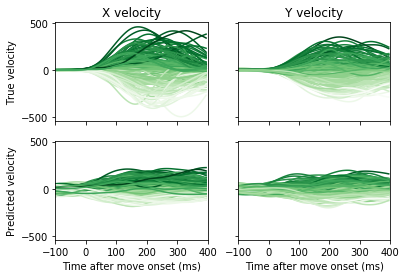

In [13]:
## Plot predicted vs true kinematics

# Coloring function
get_color = lambda idx, series: plt.get_cmap('Greens')((series[idx] - series.min()) / (series.max() - series.min()))
# Extract trial data aligned to movement onset
trial_data = dataset.make_trial_data(align_field='speed_onset', align_range=(-100, 400), allow_nans=True) 

# Initialize figure
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
# Loop through trials and plot on appropriate subplots
for tid, trial in trial_data.groupby('trial_id'):
    axs[0][0].plot(np.arange(-100, 400, dataset.bin_width), trial.finger_vel.x, color=get_color(tid, dataset.trial_info.reach_dist_x))
    axs[0][1].plot(np.arange(-100, 400, dataset.bin_width), trial.finger_vel.y, color=get_color(tid, dataset.trial_info.reach_dist_y))
    axs[1][0].plot(np.arange(-100, 400, dataset.bin_width), trial.pred_vel.x, color=get_color(tid, dataset.trial_info.reach_dist_x))
    axs[1][1].plot(np.arange(-100, 400, dataset.bin_width), trial.pred_vel.y, color=get_color(tid, dataset.trial_info.reach_dist_y))

# Add labels
axs[0][0].set_title('X velocity')
axs[0][1].set_title('Y velocity')
axs[0][0].set_ylabel('True velocity')
axs[1][0].set_ylabel('Predicted velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after move onset (ms)')
axs[0][0].set_xlim(-100, 400)
plt.show()

Clearly, linear decoding from smoothed spikes does a poor job of reconstructing true finger velocity, though it does generally differentiate reaches in the positive or negative direction.

## Summary

In this notebook, we:
* introduced the MC_RTT dataset, describing the task and provided data
* looked at what specific continuous and trial data is included
* demonstrated the task by plotting a few reach trajectories
* evaluated how accurately spike-smoothed population activity can decode hand velocity

The experimental design of the MC_RTT dataset results in much more naturalistic behavior than highly-stereotyped delayed reaching tasks, like the task of the MC_Maze dataset. The lack of pre-movement delays, clear trials, and repeated conditions make trial-averaging approaches difficult to apply and suggest that successful modeling approaches must be able to infer latent representations from single-trial data and infer the presence of unpredictable inputs to the population's activity.